# Simulation 

In [35]:
import os
import sys
sys.path.append('..')
from sfp_nsdsyn import simulation as sim
from sfp_nsdsyn import two_dimensional_model as model
from sfp_nsdsyn import utils as utils
from sfp_nsdsyn.visualization import plot_2D_model_results as vis2D
from sfp_nsdsyn.cross_validation_2d_model import plot_model_comparison_params
from gsn.perform_gsn import perform_gsn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
import json
config = json.load(open('../config.json'))
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
params = pd.read_csv('/Volumes/server/Projects/sfp_nsd/derivatives/sfp_model/results_2D/nsdsyn/summary/precision_weighted_params.csv')
params = params.query('vroinames == "V1"')
params_dict = params.to_dict(orient='records')[0]

In [64]:
# load in actual subj data
subj_list = ['subj01','subj02','subj03','subj04','subj05','subj06','subj07','subj08']

roi='V1'
all_df = pd.DataFrame({})
for subj in subj_list:
    subj_data = pd.read_csv(config['OUTPUT_DIR'] + f'dataframes/nsdsyn/model/dset-nsdsyn_sub-{subj}_roi-{roi}_vs-pRFsize_tavg-False.csv')
    subj_precision = pd.read_csv(config['OUTPUT_DIR'] + f'dataframes/nsdsyn/precision/precision-v_sub-{subj}_roi-{roi}_vs-pRFsize.csv')
    subj_data['trial'] = subj_data.groupby(['sub','voxel','class_idx']).cumcount()
    subj_data = subj_data.merge(subj_precision, on=['sub','voxel'])
    subj_data['normed_betas'] = model.normalize(subj_data, 'betas', ['sub','voxel'], phase_info=True)
    all_df = pd.concat([all_df, subj_data])

all_df.head()

,trial,image_idx,run,task,stim_idx,w_r,w_a,phase,class_idx,phase_idx,...,vroinames_x,eccrois,local_sf,local_ori,hemi,sub,vroinames_y,noise_SD,sigma_v_squared,normed_betas
0,0,105,7,memory,0,0.0,-6.0,0.000000,0,0,...,V1,3.0,0.613683,0.318386,lh,subj01,V1,0.982755,1.084998,0.149929
1,1,105,2,fixation,0,0.0,-6.0,0.000000,0,0,...,V1,3.0,0.613683,0.318386,lh,subj01,V1,0.982755,1.084998,0.048191
2,2,106,6,fixation,1,0.0,-6.0,1.570796,0,2,...,V1,3.0,0.613683,0.318386,lh,subj01,V1,0.982755,1.084998,0.016159
3,3,106,3,memory,1,0.0,-6.0,1.570796,0,2,...,V1,3.0,0.613683,0.318386,lh,subj01,V1,0.982755,1.084998,0.067219
4,4,107,1,memory,2,0.0,-6.0,3.141593,0,4,...,V1,3.0,0.613683,0.318386,lh,subj01,V1,0.982755,1.084998,0.035283


In [66]:
subj_data = all_df.query('sub == "subj01"')
subj_cov_matrix = sim.measure_noise_covariance(subj_data, 'normed_betas', 
                             new_shape=['voxel', 'class_idx', 'trial'], return_all=False)

Estimating noise covariance...done.
Estimating data covariance...done.
Estimating signal covariance...done.
Performing biconvex optimization...done.
done.


In [68]:
subj_cov_matrix.shape

(2307, 2307)

In [67]:
diagonal_entries = np.diag(subj_cov_matrix)
diagonal_entries.shape

(2307,)

In [78]:
diagonal_entries

array([0.00123957, 0.00165593, 0.00163708, ..., 0.00094683, 0.00103279,
       0.0009234 ])

In [ ]:
ee = subj_data.groupby('voxel')['sigma_v_squared'].mean().reset_index()

(2307, 2)

In [99]:
subj_data.trial

0         0
1         1
2         2
3         3
4         4
         ..
516763    3
516764    4
516765    5
516766    6
516767    7
Name: trial, Length: 516768, dtype: int64

In [111]:
syn = sim.SynthesizeData(roi='V1', n_voxels=1000, df=subj_data)
scaled_sim_data = syn.synthesize_BOLD_2d(params_dict, 
                                    grating_type='scaled', 
                                    model=7, phase_info=True)

scaled_sim_data = syn.add_noise(scaled_sim_data, 'normed_betas', n_trials=8, noise_cov=subj_cov_matrix)
scaled_sim_data.head()

,sub,w_r,w_a,class_idx,names,freq_lvl,voxel,angle,eccentricity,noise_SD,sigma_v_squared,trial,local_sf,local_ori,betas,normed_betas,noise,noisy_normed_betas
0,subj01,0.0,-6.0,0,pinwheel,0,10,5.030775,1.556064,0.982755,1.084998,0,0.613683,0.318386,0.698175,0.055679,-0.036222,0.019458
1,subj01,0.0,-11.0,1,pinwheel,1,10,5.030775,1.556064,0.982755,1.084998,0,1.125085,0.318386,0.920265,0.073391,-0.036222,0.037169
2,subj01,0.0,-20.0,2,pinwheel,2,10,5.030775,1.556064,0.982755,1.084998,0,2.045609,0.318386,1.035053,0.082545,-0.036222,0.046324
3,subj01,0.0,-37.0,3,pinwheel,3,10,5.030775,1.556064,0.982755,1.084998,0,3.784377,0.318386,0.994868,0.079340,-0.036222,0.043119
4,subj01,0.0,-69.0,4,pinwheel,4,10,5.030775,1.556064,0.982755,1.084998,0,7.057351,0.318386,0.809529,0.064560,-0.036222,0.028338


In [114]:
syn = sim.SynthesizeData(roi='V1', n_voxels=1000, df=subj_data)
scaled_sim_data = syn.synthesize_BOLD_2d(params_dict, 
                                    grating_type='scaled', 
                                    model=7, phase_info=True)

scaled_sim_data = syn.add_noise(scaled_sim_data, 'normed_betas', n_trials=8, noise_cov=subj_cov_matrix)

In [115]:
constant_sim_data = syn.synthesize_BOLD_2d(params_dict, 
                                      grating_type='constant', 
                                      model=7, phase_info=True)
constant_sim_data = syn.add_noise(constant_sim_data, 'normed_betas', n_trials=8, noise_cov=subj_cov_matrix)


In [118]:
scaled_sim_data = scaled_sim_data.groupby(['sub','voxel','class_idx']).mean().reset_index()
my_dataset = model.SpatialFrequencyDataset(scaled_sim_data, beta_col='noisy_normed_betas')
my_model = model.SpatialFrequencyModel(random_state=42)

scaled_loss_history, scaled_model_history, scaled_losses = model.fit_model(my_model, my_dataset,
                                                                            save_path=None,
                                                                            learning_rate=0.0005, max_epoch=20000,
                                                                            print_every=1000, loss_all_voxels=False)

**epoch no.0 loss: 0.0560086604
**epoch no.999 loss: 0.0082636871
**epoch no.1999 loss: 0.0021550893
**epoch no.2999 loss: 0.0008906038
**epoch no.3999 loss: 0.0003966618
**epoch no.4999 loss: 0.0001805731
**epoch no.5999 loss: 8.696e-05
**epoch no.6999 loss: 5.04616e-05
**epoch no.7999 loss: 3.92752e-05
**epoch no.8999 loss: 3.71271e-05
**epoch no.9999 loss: 3.69525e-05
**epoch no.10999 loss: 3.69494e-05
**epoch no.11999 loss: 3.69494e-05
**epoch no.12999 loss: 3.69494e-05
**epoch no.13999 loss: 3.69494e-05
**epoch no.14999 loss: 3.69494e-05
**epoch no.15999 loss: 3.69494e-05
**epoch no.16999 loss: 3.69494e-05
**epoch no.17999 loss: 3.69494e-05
**epoch no.18999 loss: 3.69494e-05
**epoch no.19999 loss: 3.69494e-05
*epoch no.20000: Finished! final model params...
 {'sigma': 2.24, 'slope': 0.15, 'intercept': 0.17, 'p_1': 0.08, 'p_2': -0.02, 'p_3': -0.04, 'p_4': -0.07, 'A_1': 0.06, 'A_2': -0.02}
Elapsed time: 168.36 sec


In [119]:
constant_sim_data = constant_sim_data.groupby(['sub','voxel','class_idx']).mean().reset_index()
my_dataset = model.SpatialFrequencyDataset(constant_sim_data, beta_col='noisy_normed_betas')
my_model = model.SpatialFrequencyModel(random_state=42)

constant_loss_history, constant_model_history, constant_losses = model.fit_model(my_model, my_dataset,
                                                                            save_path=None,
                                                                            learning_rate=0.0005, max_epoch=20000,
                                                                            print_every=1000, loss_all_voxels=False)

**epoch no.0 loss: 0.0463360959
**epoch no.999 loss: 0.0254442645
**epoch no.1999 loss: 0.0017021413
**epoch no.2999 loss: 0.0007676127
**epoch no.3999 loss: 0.0003782856
**epoch no.4999 loss: 0.0001988426
**epoch no.5999 loss: 0.0001184268
**epoch no.6999 loss: 8.62063e-05
**epoch no.7999 loss: 7.60235e-05
**epoch no.8999 loss: 7.39773e-05
**epoch no.9999 loss: 7.37979e-05
**epoch no.10999 loss: 7.37942e-05
**epoch no.11999 loss: 7.37942e-05
**epoch no.12999 loss: 7.37942e-05
**epoch no.13999 loss: 7.37942e-05
**epoch no.14999 loss: 7.37942e-05
**epoch no.15999 loss: 7.37942e-05
**epoch no.16999 loss: 7.37942e-05
**epoch no.17999 loss: 7.37942e-05
**epoch no.18999 loss: 7.37942e-05
**epoch no.19999 loss: 7.37942e-05
*epoch no.20000: Finished! final model params...
 {'sigma': 2.24, 'slope': 0.16, 'intercept': 0.16, 'p_1': 0.08, 'p_2': -0.02, 'p_3': -0.04, 'p_4': -0.07, 'A_1': 0.06, 'A_2': -0.02}
Elapsed time: 173.49 sec


In [ ]:
scaled_model_history

In [ ]:
lr=0.0005
max_epoch=30000
subj='subj01'
grating_types = ['scaled', 'constant']
noise_levels = [1,3,5,7]
noise_mapping = {'1': 'low', '3': 'middle', '5': 'high'}

pt_file_list = []
for grating, noise_lvl in itertools.product(grating_types, noise_levels):
    file_name = f'sfp_model/simulation/model-params_roi-V1_grating-scaled_cov-True_noise-{noise_lvl}_lr-{lr}_eph-{max_epoch}_basesub-{subj}.pt'
    pt_file_list.append(f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_model/simulation/' + file_name)
model_df = model.load_all_models(pt_file_list, *['grating', 'noise'])

model_df['noise'] = model_df['noise'].map(noise_mapping)
model_df['grating'] = model_df['grating'].map({'scaled': 'scaled', 'constant': 'uniform'})



In [127]:
results_df

,epoch,sigma,slope,intercept,p_1,p_2,p_3,p_4,A_1,A_2,grating,Unnamed: 0,vroinames
19999,19999.0,2.236239,0.149270,0.172612,0.081802,-0.023225,-0.037289,-0.066123,0.055920,-0.018692,scaled,NaN,NaN
19999,19999.0,2.240783,0.158689,0.158056,0.081247,-0.021973,-0.036291,-0.065842,0.055966,-0.018786,uniform,NaN,NaN
0,NaN,2.199299,0.150471,0.171367,0.080991,-0.021897,-0.036557,-0.065930,0.057589,-0.019375,ground truth,0.0,V1


(<Figure size 1728x540 with 9 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

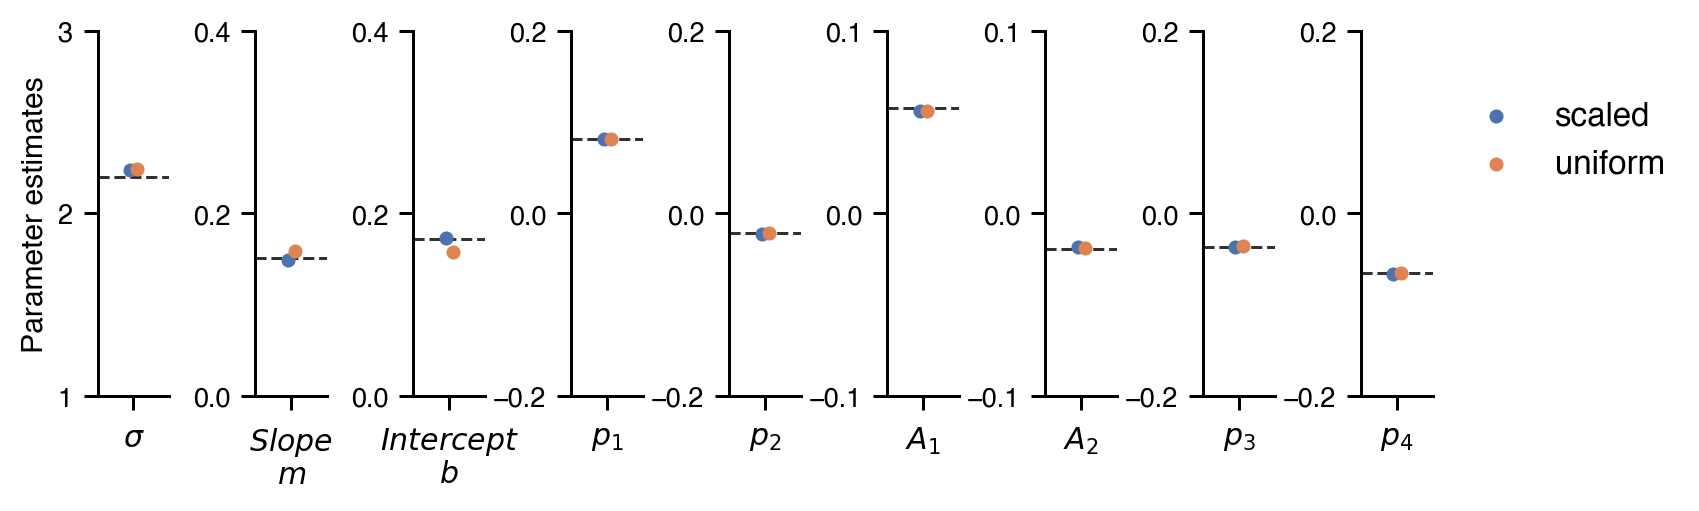

In [ ]:
params_list = ['sigma', 'slope', 'intercept', 'p_1', 'p_2', 'A_1','A_2','p_3', 'p_4']
params_vals = params[params_list].iloc[0].tolist()
# Plug in the values directly to the color map
color_map = [
    (31, 119, 180),  # blue for 'scaled'
    (174, 199, 232),  # light blue for 'scaled'
    (255, 127, 14),  # orange for 'constant'
    (255, 187, 120)  # light orange for 'constant'
]
color_map = [(r/255, g/255, b/255) for r, g, b in color_map]


ylim_list = [(1, 3), (0, 0.4),(0, 0.4), (-0.2, 0.2), (-0.2, 0.2),(-0.1,0.1),(-0.1,0.1), (-0.2, 0.2), (-0.2, 0.2)]
yticks_list=  [[1,2,3], [0, 0.2, 0.4], [0, 0.2, 0.4], [-0.2,0,0.2], [-0.2,0,0.2], [-0.1,0,0.1], [-0.1,0,0.1], [-0.2,0,0.2], [-0.2,0,0.2]]
vis2D.plot_simulation_results(model_df, params_list, ground_truth=params_vals, 
                              hue='grating', ylim=ylim_list, yticks=yticks_list, scale=0.8,
                              **{'palette': color_map, 'hue_order': ['scaled - low', 'scaled - high', 'constant - low', 'constant - high']})

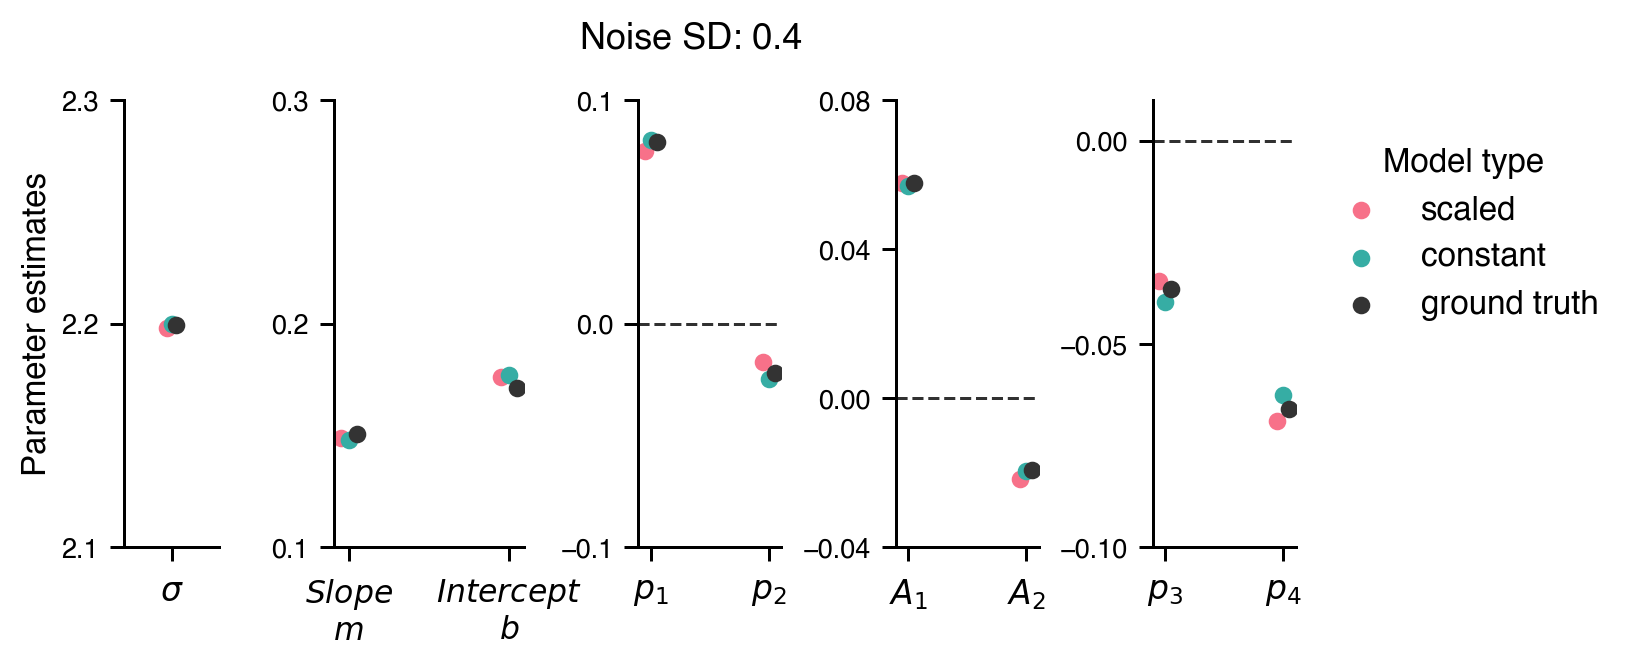

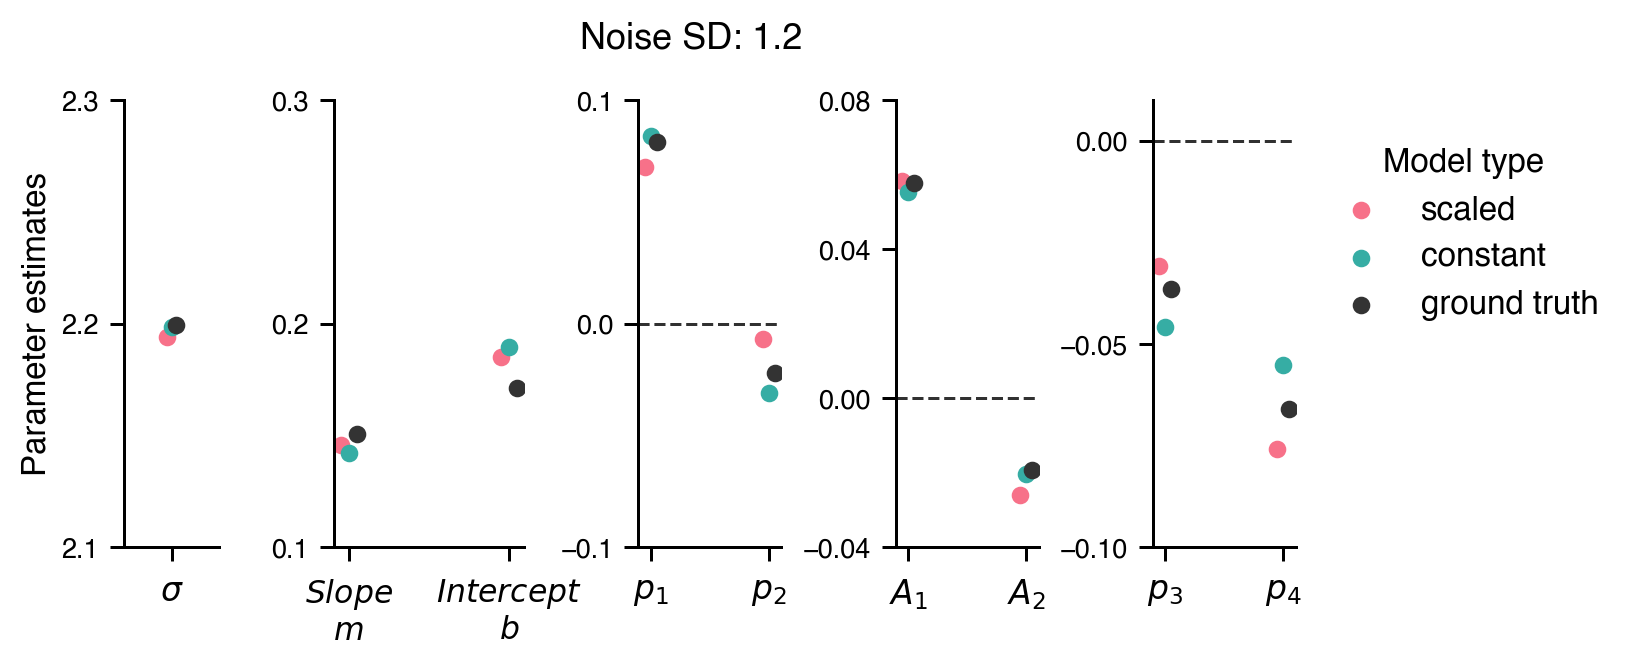

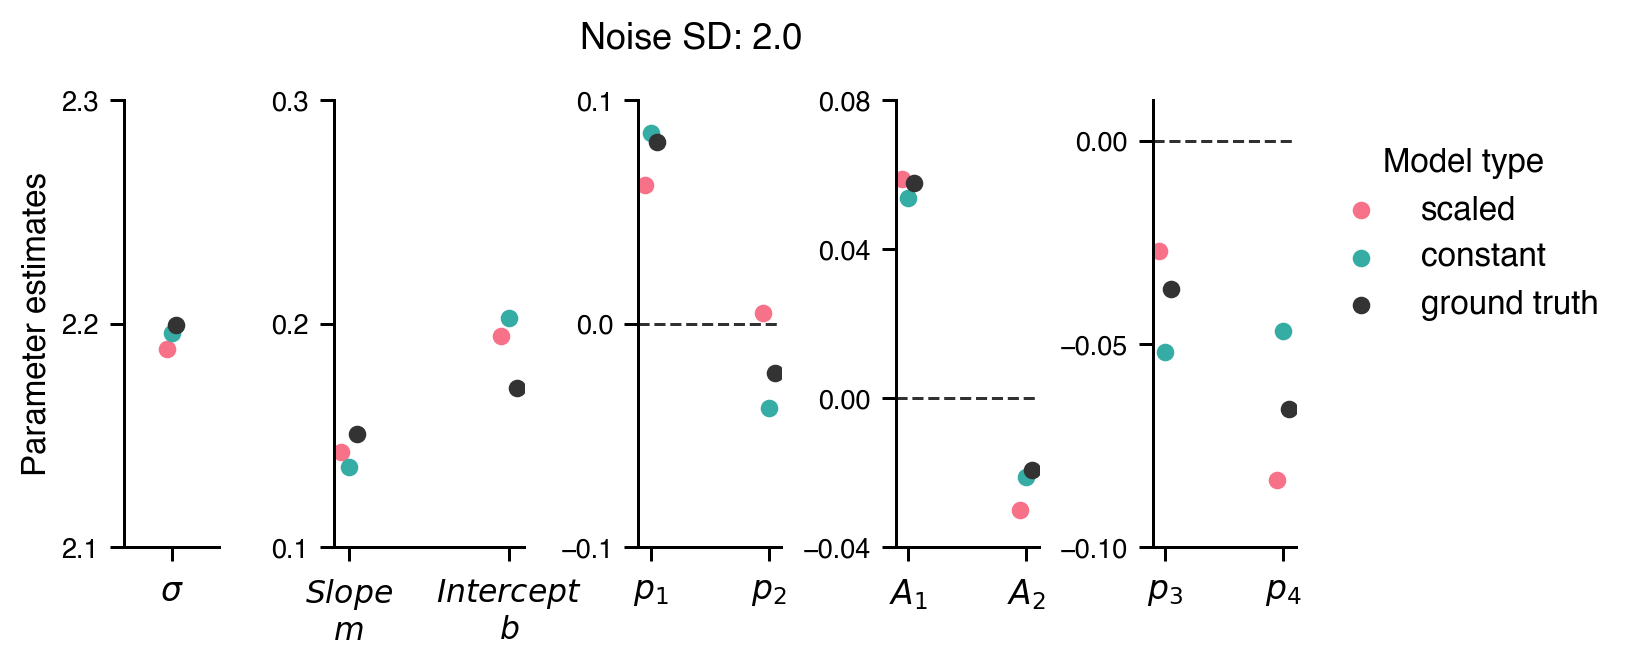

In [34]:
for noise_lvl in [1,3,5]:
    noise_lvl = str(noise_lvl)
    tmp = model_df.query('noise == @noise_lvl')
    original_params['grating'] = 'ground truth'
    original_params['noise'] = 'ground truth'
    tmp = pd.concat([tmp, original_params], axis=0)

    ylim_list = [(2.1, 2.3), (0.1, 0.3), (-0.1, 0.1),(-0.04,0.08), (-0.1, 0.01)]
    yticks_list=  [[2.1,2.2,2.3], [0.1, 0.2, 0.3], [-0.1,0,0.1], [-0.04,0,0.04,0.08], [-0.1,-0.05,0]]
    params_list = [['sigma'], ['slope', 'intercept'], ['p_1', 'p_2'], ['A_1','A_2'], ['p_3', 'p_4']]
    colors = sns.color_palette("husl", 2) + [(0.2,0.2,0.2)]  # Generate two colors from the "husl" palette and add black

    fig, axes = plt.subplots(1,5, figsize=(7,2.8), 
                            gridspec_kw={'width_ratios': [1,2,1.5,1.5,1.5]})
    save_path= os.path.join(config['OUTPUT_DIR'], 'figures', 'sfp_model', 'simulation', 'params_comparison_noise_lvl_' + noise_lvl + '.png')
    vis2D.plot_model_comparison_params(tmp, 
                                params_list = params_list, 
                                hue='grating',
                                suptitle='Noise SD: ' + str(np.round(int(noise_lvl) * 0.3995, 2)),
                                ylim=ylim_list, yticks=yticks_list,
                                fig=fig, axes=axes,
                                save_path=save_path, **{'palette': colors})
